# Quantum Galton Board — Demo
**Author:** <Your Name> • **Project:** WISER & Womanium Quantum Program 2025  
**Notebook:** galton_demo.ipynb

**Purpose:** Build, visualize, and sample the Quantum Galton Board (1-, 2-, and k-layer variants). This notebook demonstrates the canonical one-hot (CSWAP) approach and a fast parallel-coin sampler, compares outputs to analytic expectations, and saves the figures used in the report.


## Objectives
1. Review the Galton board concept and how it maps to a quantum circuit (one-hot CSWAP model).
2. Implement and draw 1-layer and 2-layer circuits to verify structure.
3. Implement a general k-layer `build_galton_circuit(k)` and demonstrate for several k (1,2,4,8).
4. Simulate on `AerSimulator` (noiseless) and plot histograms.
5. Compare measured histograms to analytic binomial distribution (overlay an analytic curve).

## Environment & imports
- Import pinned versions of qiskit / qiskit-aer, numpy, matplotlib.
- Set up the Aer simulator backend and plotting defaults.
- Note: pinning qiskit versions used for reproducibility (see `requirements.txt`).

In [1]:
#Cell 1 : Installation
# Core Qiskit Terra + Aer
!pip install qiskit==1.3
!pip install qiskit-aer==0.15
!pip install qiskit-ibm-runtime==0.34.0

# Utilities
!pip install matplotlib numpy
!pip install pylatexenc==2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 k

In [2]:
# Cell 2 : Imports
import importlib, core_galton
importlib.reload(core_galton)

from core_galton import GaltonEngine, build_galton_circuit, simulate_engine, run_galton

In [3]:
import core_galton
print(dir(core_galton))

['AerSimulator', 'Dict', 'GaltonEngine', 'GenericBackendV2', 'List', 'Optional', 'Peg', 'QuantumCircuit', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'build_galton_circuit', 'dataclass', 'plt', 'run_galton', 'simulate_engine', 'transpile']


In [4]:
import inspect
import core_galton

funcs = inspect.getmembers(core_galton, inspect.isfunction)
print([name for name, _ in funcs])

['build_galton_circuit', 'dataclass', 'run_galton', 'simulate_engine', 'transpile']


## Build & draw: 1-layer and 2-layer circuits
This cell constructs the circuits for k = 1, 2, 8, 16 using `build_galton_circuit` and displays the diagrams to verify :
- qubit allocation and naming,
- location of CSWAP/Toffoli gates,
- measurement mapping (which qubit → which classical bit).

k=1: qubits=4, cbits=2


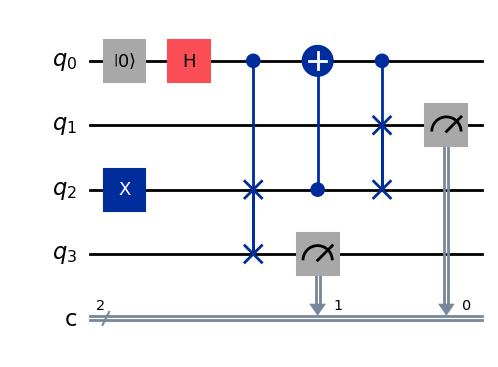

k=2: qubits=6, cbits=3


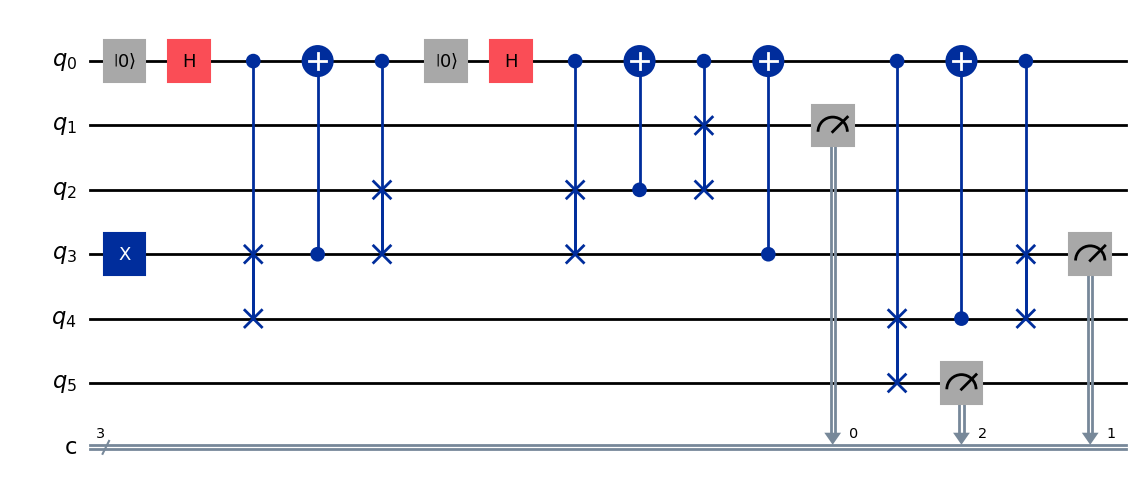

k=8: qubits=18, cbits=9


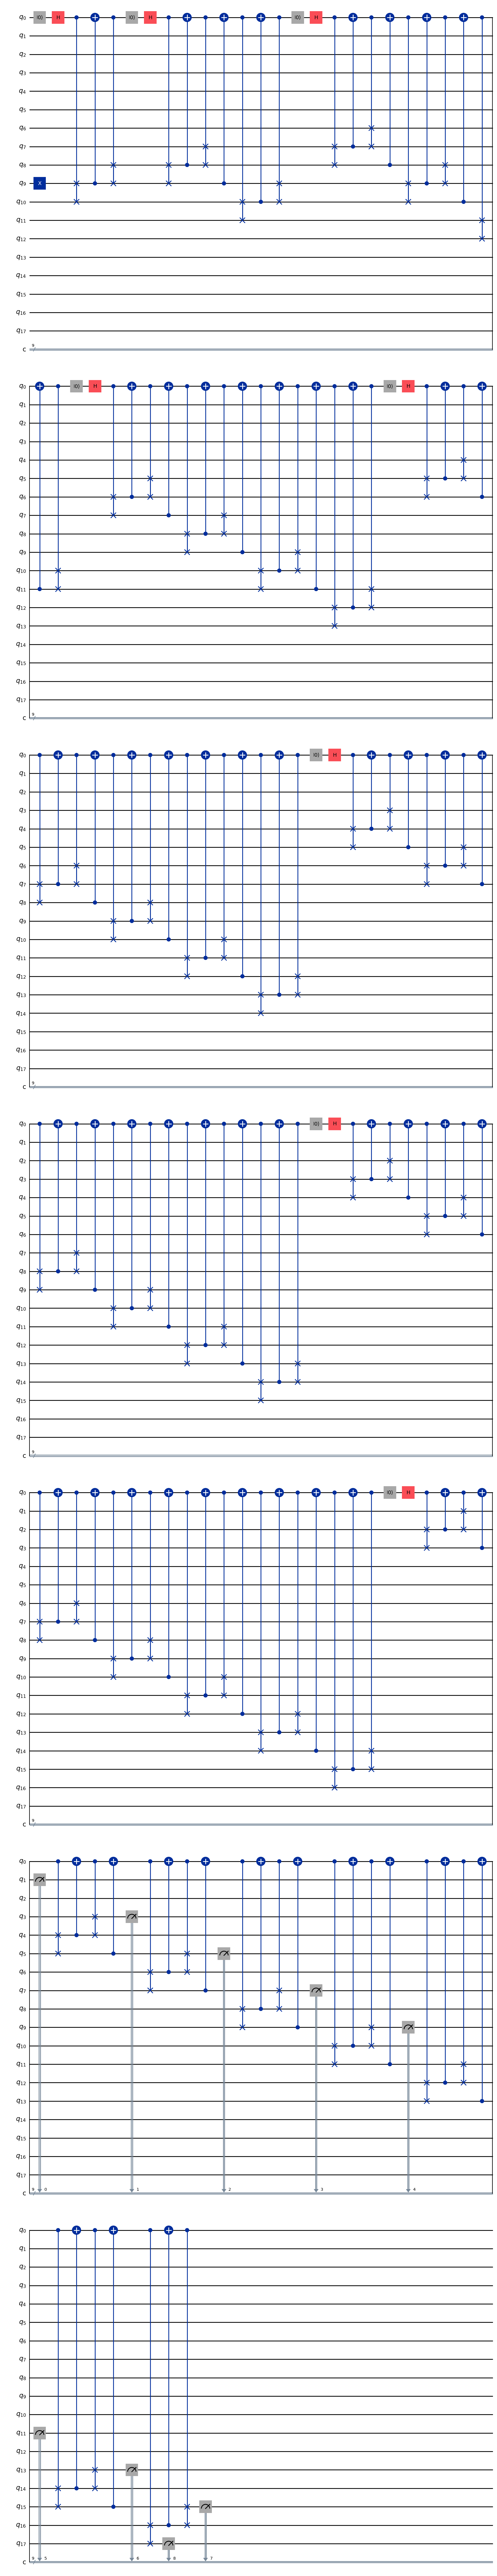

k=16: qubits=34, cbits=17


In [10]:
# Cell 3: Draw circuits
for k in [1,2,8,16]:
    qc = build_galton_circuit(k)
    print(f"k={k}: qubits={qc.num_qubits}, cbits={qc.num_clbits}")
    display(qc.draw(output='mpl'))

Implementing it for many ks (k = 2, 3, 4)

k=2  total_counts=5000  seed=1342705683


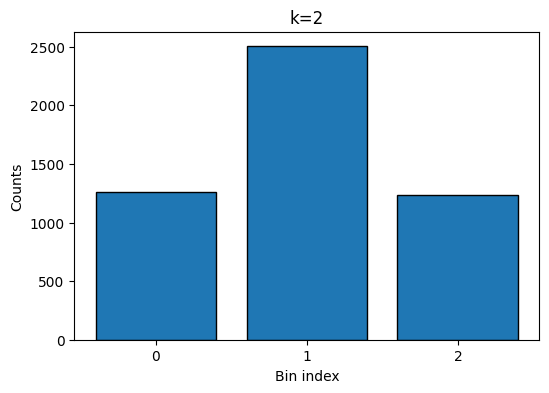

k=3  total_counts=5000  seed=710180350


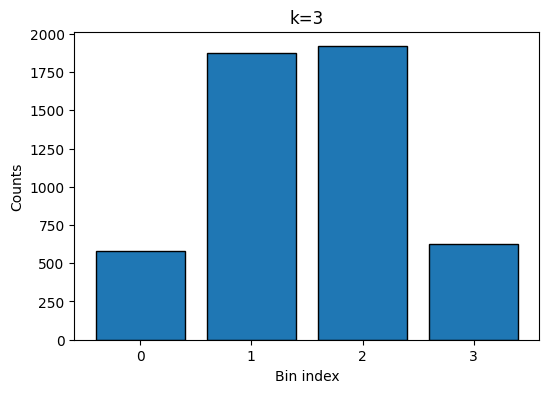

k=4  total_counts=5000  seed=244495006


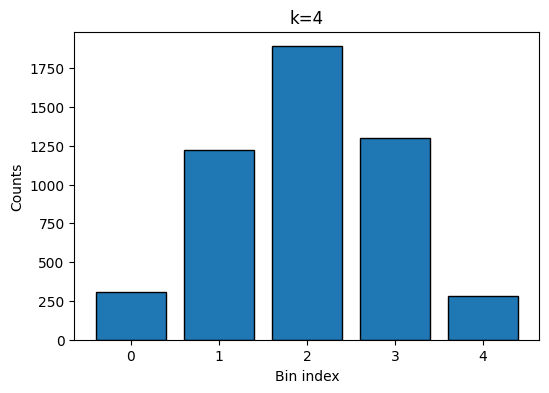

In [7]:
import numpy as np
ks = [2,3,4]
for k in ks:
    eng = GaltonEngine(layers=k, mode='full')
    # use explicit random seed each call for guaranteed fresh randomness:
    seed = np.random.randint(0, 2**31)
    counts = eng.run(shots=5000, seed=seed)
    print(f"k={k}  total_counts={sum(counts.values())}  seed={seed}")
    eng.plot(counts, title=f'k={k}')

## Implementation overview
We provide two core implementations:
- **(one-hot / CSWAP) engine** — explicit tracking of the ball via position qubits, uses coin qubit + controlled-swaps and reset between layers.
- **(parallel-coin) sampler** — simpler: apply Hadamards to k qubits in parallel and count ones (used for fast large-k experiments and sanity checks).
- These above executions are in the `core_galton.py` file.

## Quick verification tests
- Steps:
  - For k=1, expect near [0.5, 0.5] distribution.
  - Plot histogram bars for bins 0..k and overlay the analytic binomial/probability (scaled to shots).
  - For moderate k, the histogram should approximate binomial (become Gaussian-like for larger k).
- Include minimal assertions (e.g., total counts == shots, number of bins == k+1).

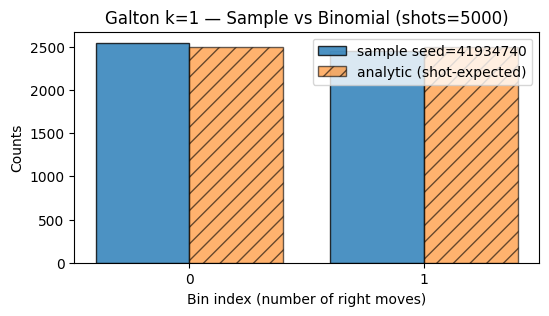

k=1  total_counts_run1=5000  seed1=41934740  seed2=533440370
sample run1 (counts): [2545, 2455]
analytic expected   : [2500, 2500]
------------------------------------------------------------


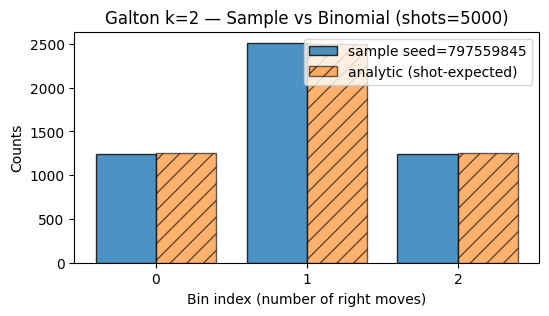

k=2  total_counts_run1=5000  seed1=797559845  seed2=1683331820
sample run1 (counts): [1246, 2513, 1241]
analytic expected   : [1250, 2500, 1250]
------------------------------------------------------------


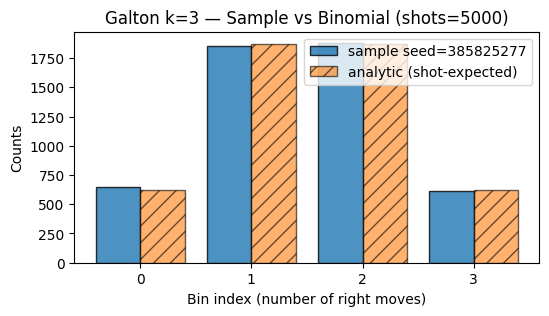

k=3  total_counts_run1=5000  seed1=385825277  seed2=1401699916
sample run1 (counts): [650, 1853, 1882, 615]
analytic expected   : [625, 1875, 1875, 625]
------------------------------------------------------------


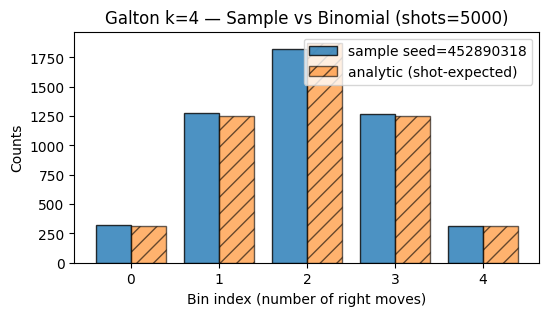

k=4  total_counts_run1=5000  seed1=452890318  seed2=599147135
sample run1 (counts): [323, 1274, 1823, 1268, 312]
analytic expected   : [312, 1250, 1875, 1250, 312]
------------------------------------------------------------


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from core_galton import GaltonEngine

ks = [1, 2, 3, 4]
shots = 5000

for k in ks:
    eng = GaltonEngine(layers=k, mode='full')

    # 1) run with a fresh (random) seed
    seed1 = np.random.randint(0, 2**31)
    counts1 = eng.run(shots=shots, seed=seed1)

    # 2) run again with a different fresh seed to demonstrate variation
    seed2 = np.random.randint(0, 2**31)
    counts2 = eng.run(shots=shots, seed=seed2)

    # Prepare plotting arrays (sorted bins 0..k)
    bins = list(range(k+1))
    y1 = [counts1.get(i, 0) for i in bins]
    y2 = [counts2.get(i, 0) for i in bins]

    # Analytic binomial PMF (n=k, p=1/2)
    from math import comb
    probs = [comb(k, i) * (0.5**k) for i in bins]
    expected = [p * shots for p in probs]

    # Plot sample vs analytic
    plt.figure(figsize=(6,3))
    plt.bar([x-0.2 for x in bins], y1, width=0.4, label=f'sample seed={seed1}', alpha=0.8, edgecolor='k')
    plt.bar([x+0.2 for x in bins], expected, width=0.4, label='analytic (shot-expected)', alpha=0.6, edgecolor='k', hatch='//')
    plt.xticks(bins)
    plt.xlabel('Bin index (number of right moves)')
    plt.ylabel('Counts')
    plt.title(f'Galton k={k} — Sample vs Binomial (shots={shots})')
    plt.legend()
    plt.show()

    # Quick console summary: totals & a small comparison
    print(f"k={k}  total_counts_run1={sum(y1)}  seed1={seed1}  seed2={seed2}")
    print("sample run1 (counts):", y1)
    print("analytic expected   :", [int(round(v)) for v in expected])
    print("-" * 60)

k= 1 total_counts= 5000


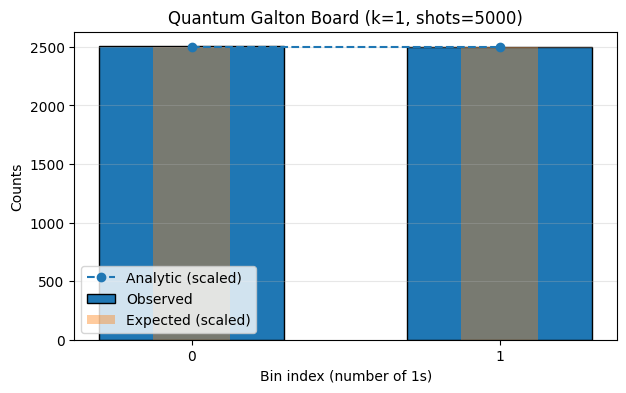

k= 2 total_counts= 5000


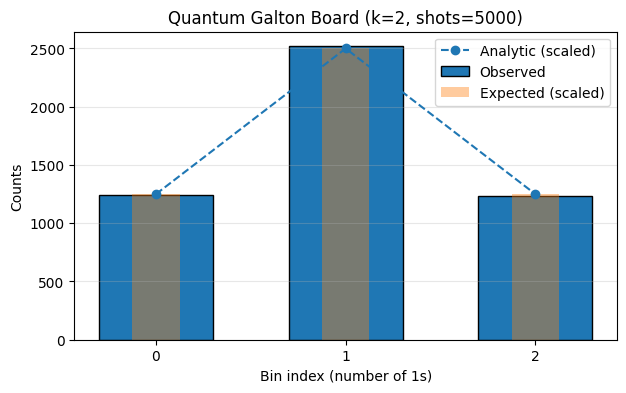

k= 4 total_counts= 5000


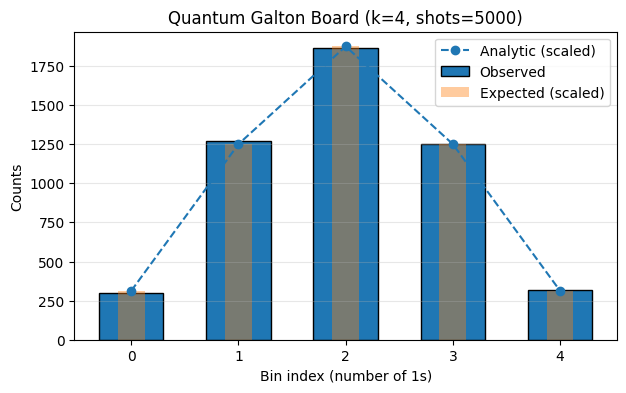

k= 16 total_counts= 5000


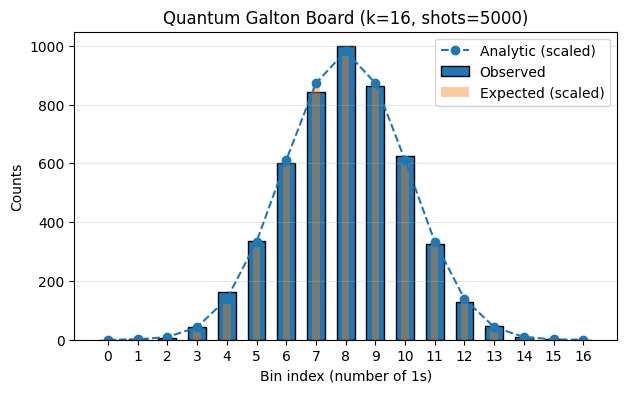

In [9]:
from quantum_galton_board import run_many_ks, plot_binomial_counts

ks = [1,2,4,16]        # pick your k values (16 might be heavy; reduce if slow)
shots = 5000
results = run_many_ks(ks, shots=shots)

for k in ks:
    counts = results[k]
    print("k=", k, "total_counts=", sum(counts.values()))
    plot_binomial_counts(counts, k, shots)